# PA6: More Regressors

Team 5: Mohammad Parsazadeh, Hadis Ebrahimi, Andrii Shcherbukha

Dataset: New York City Airbnb Open Data (AB_NYC_2019.csv)

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from google.colab import drive

import math

#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor
from sklearn import model_selection
from sklearn.metrics import median_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


## Loading data

In [3]:

drive.mount('/content/drive')


files_dir = "/content/drive/MyDrive/Colab Notebooks/datasets/"
filename = files_dir + "AB_NYC_2019.csv"

df = pd.read_csv(filename) 

Mounted at /content/drive


## Cleaning Data

In [4]:
# before moving forward there are a few 
# features that could use better names
df.rename(columns=
            {"id": "listing_id", 
             "name": "listing_title",
             "host_name":"host_first_name",
             "neighbourhood_group":"nyc_borough",
             "room_type": "property_type",
             "last_review": "last_review_date"
            },
          inplace=True)

df

listing_id                                      listing_title  \
0            2539                 Clean & quiet apt home by the park   
1            2595                              Skylit Midtown Castle   
2            3647                THE VILLAGE OF HARLEM....NEW YORK !   
3            3831                    Cozy Entire Floor of Brownstone   
4            5022   Entire Apt: Spacious Studio/Loft by central park   
...           ...                                                ...   
48890    36484665    Charming one bedroom - newly renovated rowhouse   
48891    36485057      Affordable room in Bushwick/East Williamsburg   
48892    36485431            Sunny Studio at Historical Neighborhood   
48893    36485609               43rd St. Time Square-cozy single bed   
48894    36487245  Trendy duplex in the very heart of Hell's Kitchen   

        host_id host_first_name nyc_borough       neighbourhood  latitude  \
0          2787            John    Brooklyn          Kensington  40.64749   
1          2845        Jennifer   Manhattan             Midtown  40.75362   
2          4632       Elisabeth   Manhattan              Harlem  40.80902   
3          4869     LisaRoxanne    Brooklyn        Clinton Hill  40.68514   
4          7192           Laura   Manhattan         East Harlem  40.79851   
...         ...             ...         ...                 ...       ...   
48890   8232441         Sabrina    Brooklyn  Bedford-Stuyvesant  40.67853   
48891   6570630         Marisol    Brooklyn            Bushwick  40.70184   
48892  23492952   Ilgar & Aysel   Manhattan              Harlem  40.81475   
48893  30985759             Taz   Manhattan      Hell's Kitchen  40.75751   
48894  68119814      Christophe   Manhattan      Hell's Kitchen  40.76404   

       longitude    property_type  price  minimum_nights  number_of_reviews  \
0      -73.97237     Private room    149               1                  9   
1      -73.98377  Entire home/apt    225               1                 45   
2      -73.94190     Private room    150               3                  0   
3      -73.95976  Entire home/apt     89               1                270   
4      -73.94399  Entire home/apt     80              10                  9   
...          ...              ...    ...             ...                ...   
48890  -73.94995     Private room     70               2                  0   
48891  -73.93317     Private room     40               4                  0   
48892  -73.94867  Entire home/apt    115              10                  0   
48893  -73.99112      Shared room     55               1                  0   
48894  -73.98933     Private room     90               7                  0   

      last_review_date  reviews_per_month  calculated_host_listings_count  \
0           2018-10-19               0.21                               6   
1           2019-05-21               0.38                               2   
2                  NaN                NaN                               1   
3           2019-07-05               4.64                               1   
4           2018-11-19               0.10                               1   
...                ...                ...                             ...   
48890              NaN                NaN                               2   
48891              NaN                NaN                               2   
48892              NaN                NaN                               1   
48893              NaN                NaN                               6   
48894              NaN                NaN                               1   

       availability_365  
0                   365  
1                   355  
2                   365  
3                   194  
4                     0  
...                 ...  
48890                 9  
48891                36  
48892                27  
48893                 2  
48894                23  

[48895 rows x 16 columns]

Now let's remove duplicates and rows that make little sense


In [5]:
# checking for duplicates
print(df.duplicated().any())
print(df.duplicated(subset=['listing_id']).any())

False
False


Now let's check for NAs

In [6]:
display(df.isnull().sum())
display(df.query('reviews_per_month != reviews_per_month'))

# we don't care about titles and first names
# 10,052 listings had no reviews which 
# resulted in NaN values in  
# reviews_per_month columns
# we just need to fill those out with zeros

df_clean = df.fillna({
    'reviews_per_month':0
    })

# we will deal with last review date later

listing_id                            0
listing_title                        16
host_id                               0
host_first_name                      21
nyc_borough                           0
neighbourhood                         0
latitude                              0
longitude                             0
property_type                         0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review_date                  10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

listing_id                                      listing_title  \
2            3647                THE VILLAGE OF HARLEM....NEW YORK !   
19           7750                  Huge 2 BR Upper East  Cental Park   
26           8700  Magnifique Suite au N de Manhattan - vue Cloitres   
36          11452                        Clean and Quiet in Brooklyn   
38          11943                          Country space in the city   
...           ...                                                ...   
48890    36484665    Charming one bedroom - newly renovated rowhouse   
48891    36485057      Affordable room in Bushwick/East Williamsburg   
48892    36485431            Sunny Studio at Historical Neighborhood   
48893    36485609               43rd St. Time Square-cozy single bed   
48894    36487245  Trendy duplex in the very heart of Hell's Kitchen   

        host_id  host_first_name nyc_borough       neighbourhood  latitude  \
2          4632        Elisabeth   Manhattan              Harlem  40.80902   
19        17985             Sing   Manhattan         East Harlem  40.79685   
26        26394  Claude & Sophie   Manhattan              Inwood  40.86754   
36         7355               Vt    Brooklyn  Bedford-Stuyvesant  40.68876   
38        45445          Harriet    Brooklyn            Flatbush  40.63702   
...         ...              ...         ...                 ...       ...   
48890   8232441          Sabrina    Brooklyn  Bedford-Stuyvesant  40.67853   
48891   6570630          Marisol    Brooklyn            Bushwick  40.70184   
48892  23492952    Ilgar & Aysel   Manhattan              Harlem  40.81475   
48893  30985759              Taz   Manhattan      Hell's Kitchen  40.75751   
48894  68119814       Christophe   Manhattan      Hell's Kitchen  40.76404   

       longitude    property_type  price  minimum_nights  number_of_reviews  \
2      -73.94190     Private room    150               3                  0   
19     -73.94872  Entire home/apt    190               7                  0   
26     -73.92639     Private room     80               4                  0   
36     -73.94312     Private room     35              60                  0   
38     -73.96327     Private room    150               1                  0   
...          ...              ...    ...             ...                ...   
48890  -73.94995     Private room     70               2                  0   
48891  -73.93317     Private room     40               4                  0   
48892  -73.94867  Entire home/apt    115              10                  0   
48893  -73.99112      Shared room     55               1                  0   
48894  -73.98933     Private room     90               7                  0   

      last_review_date  reviews_per_month  calculated_host_listings_count  \
2                  NaN                NaN                               1   
19                 NaN                NaN                               2   
26                 NaN                NaN                               1   
36                 NaN                NaN                               1   
38                 NaN                NaN                               1   
...                ...                ...                             ...   
48890              NaN                NaN                               2   
48891              NaN                NaN                               2   
48892              NaN                NaN                               1   
48893              NaN                NaN                               6   
48894              NaN                NaN                               1   

       availability_365  
2                   365  
19                  249  
26                    0  
36                  365  
38                  365  
...                 ...  
48890                 9  
48891                36  
48892                27  
48893                 2  
48894                23  

[10052 rows x 16 c

In [63]:
df_clean.describe()

listing_id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       48895.000000   
mean         7.029962          23.274466           1.090910   
std         20.510550          44.550582           1.597283   
min          1.000000           0.000000           0.000000   
25%          1.000000           1.000000           0.040000   
50%          3.000000           5.000000           0.370000   
75%          5.000000          24.000000           1.580000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

We probably want to look at rows where:
- price = 0
- long term renting (minimun_nights > 30)
- reviews_per_month > 30
- availability_365 = 0

In [7]:
display(df_clean.query('price == 0'))

# we got 11 rows
# 0 price makes no sense and since 
# we will be trying to predict the price
# we should probably delete those

df_clean = df_clean.query('price > 0')


listing_id                                      listing_title  \
23161    18750597  Huge Brooklyn Brownstone Living, Close to it all.   
25433    20333471      ★Hostel Style Room | Ideal Traveling Buddies★   
25634    20523843    MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)   
25753    20608117                    Sunny, Quiet Room in Greenpoint   
25778    20624541      Modern apartment in the heart of Williamsburg   
25794    20639628  Spacious comfortable master bedroom with nice ...   
25795    20639792  Contemporary bedroom in brownstone with nice view   
25796    20639914       Cozy yet spacious private brownstone bedroom   
26259    20933849                              the best you can find   
26841    21291569  Coliving in Brooklyn! Modern design / Shared room   
26866    21304320             Best Coliving space ever! Shared room.   

         host_id host_first_name nyc_borough       neighbourhood  latitude  \
23161    8993084        Kimberly    Brooklyn  Bedford-Stuyvesant  40.69023   
25433  131697576          Anisha       Bronx     East Morrisania  40.83296   
25634   15787004    Martial Loft    Brooklyn            Bushwick  40.69467   
25753    1641537          Lauren    Brooklyn          Greenpoint  40.72462   
25778   10132166         Aymeric    Brooklyn        Williamsburg  40.70838   
25794   86327101         Adeyemi    Brooklyn  Bedford-Stuyvesant  40.68173   
25795   86327101         Adeyemi    Brooklyn  Bedford-Stuyvesant  40.68279   
25796   86327101         Adeyemi    Brooklyn  Bedford-Stuyvesant  40.68258   
26259   13709292          Qiuchi   Manhattan         Murray Hill  40.75091   
26841  101970559          Sergii    Brooklyn            Bushwick  40.69211   
26866  101970559          Sergii    Brooklyn            Bushwick  40.69166   

       longitude    property_type  price  minimum_nights  number_of_reviews  \
23161  -73.95428     Private room      0               4                  1   
25433  -73.88668     Private room      0               2                 55   
25634  -73.92433     Private room      0               2                 16   
25753  -73.94072     Private room      0               2                 12   
25778  -73.94645  Entire home/apt      0               5                  3   
25794  -73.91342     Private room      0               1                 93   
25795  -73.91170     Private room      0               1                 95   
25796  -73.91284     Private room      0               1                 95   
26259  -73.97597  Entire home/apt      0               3                  0   
26841  -73.90670      Shared room      0              30                  2   
26866  -73.90928      Shared room      0              30                  5   

      last_review_date  reviews_per_month  calculated_host_listings_count  \
23161       2018-01-06               0.05                               4   
25433       2019-06-24               2.56                               4   
25634       2019-05-18               0.71                               5   
25753       2017-10-27               0.53                               2   
25778       2018-01-02               0.15                               1   
25794       2019-06-15               4.28                               6   
25795       2019-06-21               4.37                               6   
25796       2019-06-23               4.35                               6   
26259              NaN               0.00                               1   
26841       2019-06-22               0.11                               6   
26866       2019-05-24               0.26                               6   

       availability_365  
23161                28  
25433               127  
25634                 0  
25753                 0  
25778                73  
25794               176  
25795               232  
25796               222  
26259                 0  
26841               333  
26866               139

In [8]:
display(df_clean.query('minimum_nights > 11'))

# 747 rows 
# I would either remove those
# or add a new binary feature "long-term renting"
# since conditions for long-term renting could 
# be different and this could confuse our model
# 11 btw is IRQ upper fence
# we'll do it in the next section





listing_id                                      listing_title  \
6            5121                                    BlissArtsSpace!   
14           6090                      West Village Nest - Superhost   
29           9657                   Modern 1 BR / NYC / EAST VILLAGE   
36          11452                        Clean and Quiet in Brooklyn   
45          12627  Entire apartment in central Brooklyn neighborh...   
...           ...                                                ...   
48810    36445121                 UWS Spacious Master Bedroom Sublet   
48843    36453642     ☆  HUGE, SUNLIT Room - 3 min walk from Train !   
48871    36475746      A LARGE ROOM - 1 MONTH MINIMUM - WASHER&DRYER   
48879    36480292  Gorgeous 1.5 Bdr with a private yard- Williams...   
48882    36482231                          Bushwick _ Myrtle-Wyckoff   

         host_id host_first_name nyc_borough              neighbourhood  \
6           7356           Garon    Brooklyn         Bedford-Stuyvesant   
14         11975           Alina   Manhattan               West Village   
29         21904            Dana   Manhattan               East Village   
36          7355              Vt    Brooklyn         Bedford-Stuyvesant   
45         49670            Rana    Brooklyn  Prospect-Lefferts Gardens   
...          ...             ...         ...                        ...   
48810  274014453         Dagmara   Manhattan            Upper West Side   
48843   53966115            Nora    Brooklyn         Bedford-Stuyvesant   
48871  144008701       Ozzy Ciao   Manhattan                     Harlem   
48879     540335             Lee    Brooklyn               Williamsburg   
48882   66058896           Luisa    Brooklyn                   Bushwick   

       latitude  longitude    property_type  price  minimum_nights  \
6      40.68688  -73.95596     Private room     60              45   
14     40.73530  -74.00525  Entire home/apt    120              90   
29     40.72920  -73.98542  Entire home/apt    180              14   
36     40.68876  -73.94312     Private room     35              60   
45     40.65944  -73.96238  Entire home/apt    150              29   
...         ...        ...              ...    ...             ...   
48810  40.79952  -73.96003     Private room     75              30   
48843  40.69635  -73.93743     Private room     45              29   
48871  40.82233  -73.94687     Private room     35              29   
48879  40.71728  -73.94394  Entire home/apt    120              20   
48882  40.69652  -73.91079     Private room     40              20   

       number_of_reviews last_review_date  reviews_per_month  \
6                     49       2017-10-05               0.40   
14                    27       2018-10-31               0.22   
29                    29       2019-04-19               0.24   
36                     0              NaN               0.00   
45                    11       2019-06-05               0.49   
...                  ...              ...                ...   
48810                  0              NaN               0.00   
48843                  0              NaN               0.00   
48871                  0              NaN               0.00   
48879                  0              NaN               0.00   
48882                  0              NaN               0.00   

       calculated_host_listings_count  availability_365  
6                                   1                 0  
14                                  1                 0  
29                                  1                67  
36                                  1               365  
45                                  1                95  
...                               ...               ...  
48810                               1                90  
48843                               2               341  
48871                               2                31  
48879                               1              

In [9]:
display(df_clean.query('reviews_per_month > 30'))

# even if we assume the property is booked for 1 night every night, 
# 58.5 reviews per months appears implausible 
# (as far as I know only guests can leave reviews, 
# so even if I ask my friends to join me in tanking the 
# rating of the property, airbnb won't allow that) 

df_clean = df_clean.query('reviews_per_month < 31')

listing_id                                      listing_title  \
42075    32678719  Enjoy great views of the City in our Deluxe Room!   

         host_id host_first_name nyc_borough     neighbourhood  latitude  \
42075  244361589         Row NYC   Manhattan  Theater District  40.75918   

       longitude property_type  price  minimum_nights  number_of_reviews  \
42075  -73.98801  Private room    100               1                156   

      last_review_date  reviews_per_month  calculated_host_listings_count  \
42075       2019-07-07               58.5                               9   

       availability_365  
42075               299

In [11]:
display(df_clean.query('availability_365 == 0'))

# 12,686 rows that's about the quarter of our datapoints
# 0 availability could mean that the owner did not want to
# delist the property but it was temporarily unavailable
# e.g. due to renovations.
# I don't think availability has any effect on the price
# which we try to predict, so we can just remove that feature
# but keep the rows 

listing_id                                      listing_title  \
4            5022   Entire Apt: Spacious Studio/Loft by central park   
6            5121                                    BlissArtsSpace!   
8            5203                 Cozy Clean Guest Room - Family Apt   
14           6090                      West Village Nest - Superhost   
20           7801                   Sweet and Spacious Brooklyn Loft   
...           ...                                                ...   
48550    36313048    Sunny room with private entrance in shared home   
48731    36410519    Sunlight charming apt. in the heart of Brooklyn   
48756    36419441                            Murray Hill Masterpiece   
48760    36420725  Sunnyside, Queens 15 Mins to Midtown Clean & C...   
48779    36424776  Queen size bedroom in two bed apt with great l...   

         host_id host_first_name nyc_borough       neighbourhood  latitude  \
4           7192           Laura   Manhattan         East Harlem  40.79851   
6           7356           Garon    Brooklyn  Bedford-Stuyvesant  40.68688   
8           7490       MaryEllen   Manhattan     Upper West Side  40.80178   
14         11975           Alina   Manhattan        West Village  40.73530   
20         21207           Chaya    Brooklyn        Williamsburg  40.71842   
...          ...             ...         ...                 ...       ...   
48550   16883913         Tiffany      Queens           Ridgewood  40.69919   
48731  121384174   Luciana Paula    Brooklyn          Park Slope  40.66716   
48756  273824202           David   Manhattan         Murray Hill  40.74404   
48760   19990280         Brandon      Queens           Sunnyside  40.74719   
48779   13384464          Hollie    Brooklyn  Bedford-Stuyvesant  40.69617   

       longitude    property_type  price  minimum_nights  number_of_reviews  \
4      -73.94399  Entire home/apt     80              10                  9   
6      -73.95596     Private room     60              45                 49   
8      -73.96723     Private room     79               2                118   
14     -74.00525  Entire home/apt    120              90                 27   
20     -73.95718  Entire home/apt    299               3                  9   
...          ...              ...    ...             ...                ...   
48550  -73.89902     Private room     45               1                  0   
48731  -73.98101  Entire home/apt    111               8                  0   
48756  -73.97239  Entire home/apt    129               2                  0   
48760  -73.91919     Private room     46               1                  0   
48779  -73.94198     Private room     50               3                  0   

      last_review_date  reviews_per_month  calculated_host_listings_count  \
4           2018-11-19               0.10                               1   
6           2017-10-05               0.40                               1   
8           2017-07-21               0.99                               1   
14          2018-10-31               0.22                               1   
20          2011-12-28               0.07                               1   
...                ...                ...                             ...   
48550              NaN               0.00                               1   
48731              NaN               0.00                               1   
48756              NaN               0.00                               1   
48760              NaN               0.00                               1   
48779              NaN               0.00                               1   

       availability_365  
4                     0  
6                     0  
8                     0  
14                    0  
20                    0  
...                 ...  
48550                 0  
48731                 0  
48756                 0  
48760                 0  
48779                 0  

[17530 rows x 16 c

So let's remove columns we won't need

In [10]:
df_clean.drop([
        "listing_id", # listing id does not give us any valuable information
        "listing_title", # listing title could potentially be analyzed for key words, but not in this PA
        "host_id", # host id and host name do not give us any valuable information
        "host_first_name",
        #"latitude", # for location, we're going to use boroughs and neighbourhoods 
        #"longitude",# so lat and long can go
        #'availability_365' # explained above
        ],
        axis=1, 
        inplace=True
        )

display(df_clean)
display(df_clean.shape)

nyc_borough       neighbourhood  latitude  longitude    property_type  \
0        Brooklyn          Kensington  40.64749  -73.97237     Private room   
1       Manhattan             Midtown  40.75362  -73.98377  Entire home/apt   
2       Manhattan              Harlem  40.80902  -73.94190     Private room   
3        Brooklyn        Clinton Hill  40.68514  -73.95976  Entire home/apt   
4       Manhattan         East Harlem  40.79851  -73.94399  Entire home/apt   
...           ...                 ...       ...        ...              ...   
48890    Brooklyn  Bedford-Stuyvesant  40.67853  -73.94995     Private room   
48891    Brooklyn            Bushwick  40.70184  -73.93317     Private room   
48892   Manhattan              Harlem  40.81475  -73.94867  Entire home/apt   
48893   Manhattan      Hell's Kitchen  40.75751  -73.99112      Shared room   
48894   Manhattan      Hell's Kitchen  40.76404  -73.98933     Private room   

       price  minimum_nights  number_of_reviews last_review_date  \
0        149               1                  9       2018-10-19   
1        225               1                 45       2019-05-21   
2        150               3                  0              NaN   
3         89               1                270       2019-07-05   
4         80              10                  9       2018-11-19   
...      ...             ...                ...              ...   
48890     70               2                  0              NaN   
48891     40               4                  0              NaN   
48892    115              10                  0              NaN   
48893     55               1                  0              NaN   
48894     90               7                  0              NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  
0                   0.21                               6               365  
1                   0.38                               2               355  
2                   0.00                               1               365  
3                   4.64                               1               194  
4                   0.10                               1                 0  
...                  ...                             ...               ...  
48890               0.00                               2                 9  
48891               0.00                               2                36  
48892               0.00                               1                27  
48893               0.00                               6                 2  
48894               0.00                               1                23  

[48883 rows x 12 columns]

(48883, 12)

## Feature Engineering

In [11]:
# adding long term rent feature

#fig = px.histogram(df, x=df_clean['minimum_nights'], marginal="box", nbins=400)
#fig.show()

df_clean['short_term_rent'] = (df_clean['minimum_nights'] < 2).astype(int)
df_clean['medium_term_rent'] = ((df_clean['minimum_nights'] > 1) & (df_clean['minimum_nights'] <= 14)).astype(int)
df_clean['long_term_rent'] = (df_clean['minimum_nights'] > 14).astype(int)

# adding months on market column
# df_clean['months_on_market'] = df_clean['number_of_reviews'] / df_clean['reviews_per_month']


### One-hot encoding

In [12]:
# property type
display(df_clean.property_type.unique())

# since these are going to be column names
# we need to lowercase them and remove spaces
df_clean['property_type'] = (df_clean['property_type']
                                  .str.lower()
                                  .replace(' ', '_', regex=True)
                            )

df_clean = pd.get_dummies(df_clean, prefix=['type'], columns=['property_type'])
display(df_clean)

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

nyc_borough       neighbourhood  latitude  longitude  price  \
0        Brooklyn          Kensington  40.64749  -73.97237    149   
1       Manhattan             Midtown  40.75362  -73.98377    225   
2       Manhattan              Harlem  40.80902  -73.94190    150   
3        Brooklyn        Clinton Hill  40.68514  -73.95976     89   
4       Manhattan         East Harlem  40.79851  -73.94399     80   
...           ...                 ...       ...        ...    ...   
48890    Brooklyn  Bedford-Stuyvesant  40.67853  -73.94995     70   
48891    Brooklyn            Bushwick  40.70184  -73.93317     40   
48892   Manhattan              Harlem  40.81475  -73.94867    115   
48893   Manhattan      Hell's Kitchen  40.75751  -73.99112     55   
48894   Manhattan      Hell's Kitchen  40.76404  -73.98933     90   

       minimum_nights  number_of_reviews last_review_date  reviews_per_month  \
0                   1                  9       2018-10-19               0.21   
1                   1                 45       2019-05-21               0.38   
2                   3                  0              NaN               0.00   
3                   1                270       2019-07-05               4.64   
4                  10                  9       2018-11-19               0.10   
...               ...                ...              ...                ...   
48890               2                  0              NaN               0.00   
48891               4                  0              NaN               0.00   
48892              10                  0              NaN               0.00   
48893               1                  0              NaN               0.00   
48894               7                  0              NaN               0.00   

       calculated_host_listings_count  availability_365  short_term_rent  \
0                                   6               365                1   
1                                   2               355                1   
2                                   1               365                0   
3                                   1               194                1   
4                                   1                 0                0   
...                               ...               ...              ...   
48890                               2                 9                0   
48891                               2                36                0   
48892                               1                27                0   
48893                               6                 2                1   
48894                               1                23                0   

       medium_term_rent  long_term_rent  type_entire_home/apt  \
0                     0               0                     0   
1                     0               0                     1   
2                     1               0                     0   
3                     0               0                     1   
4                     1               0                     1   
...                 ...             ...                   ...   
48890                 1               0                     0   
48891                 1               0                     0   
48892                 1               0                     1   
48893                 0               0                     0   
48894                 1               0                     0   

       type_private_room  type_shared_room  
0                      1                 0  
1                      0                 0  
2                      1                 0  
3                      0                 0  
4                      0                 0  
...                  ...               ...  
48890                  1                 0  
48891                  1                 0  
48892                  0                 0  
48893                  0                 1  
48894                  1   

In [13]:
# neighbourhoods


display(df_clean.nyc_borough.unique())

# since these are going to be column names
# we need to lowercase them and remove spaces
df_clean['neighbourhood'] = (df_clean['neighbourhood']
                                  .str.lower()
                                  #.replace('.', ' ', regex=True)
                                  .replace(' ', '_', regex=True)
                            )

df_clean = pd.get_dummies(df_clean, prefix=['neighbourhood'], columns=['neighbourhood'], drop_first=True)

display(df_clean)


array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

nyc_borough  latitude  longitude  price  minimum_nights  \
0        Brooklyn  40.64749  -73.97237    149               1   
1       Manhattan  40.75362  -73.98377    225               1   
2       Manhattan  40.80902  -73.94190    150               3   
3        Brooklyn  40.68514  -73.95976     89               1   
4       Manhattan  40.79851  -73.94399     80              10   
...           ...       ...        ...    ...             ...   
48890    Brooklyn  40.67853  -73.94995     70               2   
48891    Brooklyn  40.70184  -73.93317     40               4   
48892   Manhattan  40.81475  -73.94867    115              10   
48893   Manhattan  40.75751  -73.99112     55               1   
48894   Manhattan  40.76404  -73.98933     90               7   

       number_of_reviews last_review_date  reviews_per_month  \
0                      9       2018-10-19               0.21   
1                     45       2019-05-21               0.38   
2                      0              NaN               0.00   
3                    270       2019-07-05               4.64   
4                      9       2018-11-19               0.10   
...                  ...              ...                ...   
48890                  0              NaN               0.00   
48891                  0              NaN               0.00   
48892                  0              NaN               0.00   
48893                  0              NaN               0.00   
48894                  0              NaN               0.00   

       calculated_host_listings_count  availability_365  ...  \
0                                   6               365  ...   
1                                   2               355  ...   
2                                   1               365  ...   
3                                   1               194  ...   
4                                   1                 0  ...   
...                               ...               ...  ...   
48890                               2                 9  ...   
48891                               2                36  ...   
48892                               1                27  ...   
48893                               6                 2  ...   
48894                               1                23  ...   

       neighbourhood_westerleigh  neighbourhood_whitestone  \
0                              0                         0   
1                              0                         0   
2                              0                         0   
3                              0                         0   
4                              0                         0   
...                          ...                       ...   
48890                          0                         0   
48891                          0                         0   
48892                          0                         0   
48893                          0                         0   
48894                          0                         0   

       neighbourhood_williamsbridge  neighbourhood_williamsburg  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   
...                             ...                         ...   
48890                             0                           0   
48891                             0                           0   
48892                             0                           0   
48893                             0                           0   
48894                             0                           0   

       neighbourhood_willowbrook  neighbourhood_windsor_terrace  \
0                              0                              0   
1  

In [15]:
"""
# nyc_borough
# I'm not sure if having boroughs helps us
# since usually the more granular
# the data is the better and we have neoghbourhood
# will keep boroughs for now

display(df_clean.nyc_borough.unique())

# since these are going to be column names
# we need to lowercase them and remove spaces
df_clean['nyc_borough'] = (df_clean['nyc_borough']
                                      .str.lower()
                                      .replace(' ', '_', regex=True)
                          )

df_clean = pd.get_dummies(df_clean, prefix=['borough'], columns=['nyc_borough'], drop_first=True)
display(df_clean)
"""

"\n# nyc_borough\n# I'm not sure if having boroughs helps us\n# since usually the more granular\n# the data is the better and we have neoghbourhood\n# will keep boroughs for now\n\ndisplay(df_clean.nyc_borough.unique())\n\n# since these are going to be column names\n# we need to lowercase them and remove spaces\ndf_clean['nyc_borough'] = (df_clean['nyc_borough']\n                                      .str.lower()\n                                      .replace(' ', '_', regex=True)\n                          )\n\ndf_clean = pd.get_dummies(df_clean, prefix=['borough'], columns=['nyc_borough'], drop_first=True)\ndisplay(df_clean)\n"

In [14]:
# last_review_date

# originally I wanted to generate days since last review
# feature, but I would work poorly with NAs
# so perhaps we can add a few features indicating 
# whether last review was within last 6 and 12 months

# since we do not know when the dataset was created
# we will count from the latest available date 

df_clean['last_review_date'] = pd.to_datetime(df_clean['last_review_date']).dt.date

max_date = max(df_clean['last_review_date'])

df_clean['reviewed_in_last_6_months'] = \
  df_clean.last_review_date.between(max_date - pd.DateOffset(months=6), max_date).astype(int)

df_clean['reviewed_in_last_12_months'] = \
  df_clean.last_review_date.between(max_date - pd.DateOffset(months=6), max_date).astype(int)


# and now we can remove last_review_date
df_clean.drop(labels=['last_review_date'], inplace=True, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Let's look at our price values distribution:

In [16]:
fig = px.histogram(df, x=df_clean['price'], marginal="box", nbins=100)
fig.show()

To try to compensate for the skewed distribution, we will use log of the price and see if that makes any difference.

In [17]:
df_clean['price_log'] = df_clean['price'].apply(lambda x: math.log(x))

fig = px.histogram(df, x=df_clean['price_log'], marginal="box", nbins=100)
fig.show()

In [18]:
y_trans = quantile_transform(
    df_clean['price'].to_frame(), n_quantiles=1000, output_distribution="normal", copy=True
).squeeze()
fig = px.histogram(x=y_trans, marginal="box", nbins=100)
fig.show()

### Labeling

In [15]:
label_name = 'price'
label_name_alternative = 'price_log'

all_features = np.array

numerical_feature_names = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
    ]

non_numerical_feature_names = (
    df_clean[df_clean.columns.difference(
                                         numerical_feature_names 
                                         + ['nyc_borough']
                                         + ['neighbourhood']
                                         + ['last_review_date']
                                         + [label_name]
                                         + [label_name_alternative]
                                         + ['latitude']
                                         + ['longitude']
                                         )]
                               .columns
    )

print(non_numerical_feature_names)

numerical_feature_names = [
    #"minimum_nights",
    #"number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
    ]

all_features = np.concatenate((numerical_feature_names, non_numerical_feature_names))


#print(all_features)

Index(['availability_365', 'long_term_rent', 'medium_term_rent',
       'neighbourhood_arden_heights', 'neighbourhood_arrochar',
       'neighbourhood_arverne', 'neighbourhood_astoria',
       'neighbourhood_bath_beach', 'neighbourhood_battery_park_city',
       'neighbourhood_bay_ridge',
       ...
       'neighbourhood_woodhaven', 'neighbourhood_woodlawn',
       'neighbourhood_woodrow', 'neighbourhood_woodside',
       'reviewed_in_last_12_months', 'reviewed_in_last_6_months',
       'short_term_rent', 'type_entire_home/apt', 'type_private_room',
       'type_shared_room'],
      dtype='object', length=229)


## 0. Splitting test and train data

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_clean[all_features], df_clean[label_name], test_size=0.2, random_state=23)

## 1. Linear Regression

1. Use scikit-learn’s sklearn.neighbors.KNeighborsRegressor to implement a
k-NN regressor for your dataset. Note: As you saw in the lecture there are two approaches
to determine the weights for k-NN regression, equal weights and inverse distance weighted
average. You want to try both methods and compare the results and use the best one for the
other sections.
a. The default hyperparameter for the function is weights=’uniform’, meaning all points
in the neighborhood are weighted equally. First run the method with this default.
b. Now set the weights=’distance’. This will weight the points by the inverse of their
distance so that closer points have more influence than those that are further away.
2. Use scikit-learn’s sklearn.tree.DecisionTreeRegressor to implement a
decision tree regressor.
3. Use scikit-learn’s sklearn.ensemble.RandomForestRegressor to implement a
random forest regressor for your dataset.
4. Classifier: Use scikit-learn’s sklearn.ensemble.RandomForestClassifier to
implement a random forest classifier for your dataset, meaning, you should be using a
categorical label.

In [23]:
df_clean_2 = df_clean.copy()

df_clean_2 = df_clean_2.query('availability_365 > 14')
#df_clean_2 = df_clean_2.query('price < 300')
df_clean_2 = df_clean_2.query('reviewed_in_last_12_months == 1')

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_clean_2[all_features], df_clean_2[label_name], test_size=0.2, random_state=23)

regr = DecisionTreeRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Coefficient of determination:{r2_score (y_test, y_pred)}')
print("-------------------------------/n")

#fig = px.scatter(x=y_test.to_numpy(), y=y_pred)
#fig.show()


numeric_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])


pt = PowerTransformer()

#df_clean_2['price'].hist(figsize=(14, 5));

df_clean_2['price'] = pd.DataFrame(pt.fit_transform(df_clean_2[['price']]), columns=['price'])

#df_clean_2['price'].hist(figsize=(14, 5));

numeric_pipeline = Pipeline(steps=[
    #('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_feature_names),
    #('category', categorical_pipeline, categorical_features)
])

pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', regr)
])

_ = pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Coefficient of determination:{r2_score (y_test, y_pred)}')

fig = px.scatter(x=y_test.to_numpy(), y=y_pred)
fig.show()

Mean Absolute Error: 68.87506500260011
Mean Squared Error: 26467.704693187727
Root Mean Squared Error: 162.68898147443093
Coefficient of determination:-0.16497036017219258
-------------------------------/n
Mean Absolute Error: 84.4801028065249
Mean Squared Error: 28143.258800587384
Root Mean Squared Error: 167.75952670589942
Coefficient of determination:-0.23871951577947037


Index(['listing_id', 'listing_title', 'host_id', 'host_first_name',
       'nyc_borough', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review_date', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
####################  KNeighborsRegressor  ####################
Best parameter set: {'model__n_neighbors': 20, 'model__weights': 'uniform'}

Performance on the test data:
Mean Absolute Error: 77.85304796972487
Mean Squared Error: 65313.361957400026
Root Mean Squared Error: 255.56479013627842
Coefficient of determination:0.08049051504146298





####################  DecisionTreeRegressor  ####################
Best parameter set: {'model__max_depth': 5, 'model__splitter': 'best'}

Performance on the test data:
Mean Absolute Error: 75.28799167924399
Mean Squared Error: 65551.93561587496
Root Mean Squared Error: 256.03112235795663
Coefficient of determination:0.07713177289047646





####################  RandomForestRegressor  ####################
Best parameter set: {'model__max_depth': 7, 'model__n_estimators': 500}

Performance on the test data:
Mean Absolute Error: 74.33500810278738
Mean Squared Error: 68645.12853042116
Root Mean Squared Error: 262.0021536751581
Coefficient of determination:0.03358447814875287


"\nlreg = LinearRegression()\nlreg.fit(X_train, y_train)\ny_hat = lreg.predict(X_test)\n\nprint('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat))\nprint('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat))\nprint('Root Mean Squared Error:',\nnp.sqrt(metrics.mean_squared_error(y_test, y_hat)))\nprint(f'Coefficient of determination:{r2_score (y_test, y_hat)}')\n\n"

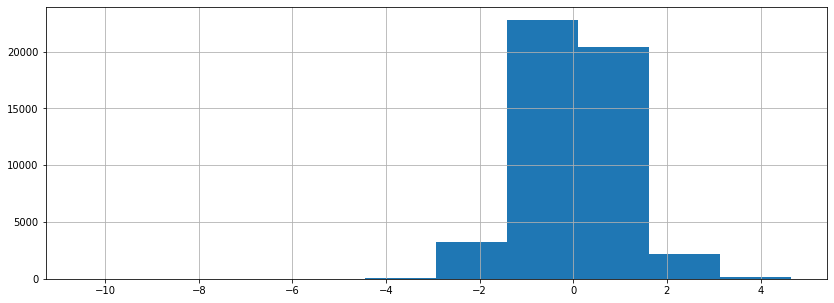

In [60]:
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
frc = RandomForestClassifier()


pt = PowerTransformer()

df_clean_2 = df.copy()

print(df.columns)


exit(1)
df_clean_2['price'] = pd.DataFrame(pt.fit_transform(df_clean_2[['price']]), columns=['price'])
df_clean_2['price'].hist(figsize=(14, 5));
#X_train, X_test, y_train, y_test = model_selection.train_test_split(df_clean_2[all_features], df_clean_2[label_name], test_size=0.2, random_state=23)

params_knr = {'model__weights':['uniform', 'distance'], 
              'model__n_neighbors':[5, 10, 20] # default is 5
              } 
params_dtr = {'model__splitter':['best', 'random'], # default is best
              'model__max_depth': [5, 10, 20] # default is None
              }  
params_rfr = {'model__n_estimators': [50, 100, 200, 500], # default is 100
              'model__max_depth': [5, 7, 10] # default is None
              }
params_frc = {'model__n_estimators': [50, 100, 200], # default is 100
              'model__max_depth': [5, 7, 10] # default is None
              }

numeric_transformer = Pipeline(
        [
            ("scaler", StandardScaler())
        ]
)


preprocessor = ColumnTransformer(
    [
        #("categoricals", categorical_transformer, non_numerical_feature_names),
        ("numericals", numeric_transformer, numerical_feature_names)
    ],
    remainder="passthrough"
)


  
def model_building (X_train, X_test, y_train, y_test, model, params, cv=5):

    regr_trans = TransformedTargetRegressor(
        regressor=model,
        transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
        )
    
    pipe = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("model", model)
        ]
    )

   
    #gridsearch parameters
    params = params


    #gridsearch 
    grid = GridSearchCV(
      pipe, 
      params, 
      cv=cv, 
      scoring = "r2", 
      )

    #results
    grid.fit(X_train, y_train)
    print(f'Best parameter set: {grid.best_params_}\n')
    best = grid.best_estimator_
    y_hat = best.predict(X_test)
    
    print('Performance on the test data:')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_hat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_hat)}')
    print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, y_hat))}')
    print(f'Coefficient of determination:{r2_score (y_test, y_hat)}')
    
    fig = px.scatter(y_hat, y_test.to_numpy())
    fig.show()

    



print("####################  KNeighborsRegressor  ####################")
model_building(X_train, X_test, y_train, y_test, knr, params_knr)

print("\n\n")

print("####################  DecisionTreeRegressor  ####################")
model_building(X_train, X_test, y_train, y_test, dtr, params_dtr)
print("\n\n")


print("####################  RandomForestRegressor  ####################")
model_building(X_train, X_test, y_train, y_test, rfr, params_rfr)


"""
lreg = LinearRegression()
lreg.fit(X_train, y_train)
y_hat = lreg.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat))
print('Root Mean Squared Error:',
np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
print(f'Coefficient of determination:{r2_score (y_test, y_hat)}')

"""

Algorithm       | MAE  | MSE | RMSE | R2 Score
-----|----|-----|------|-----
Linear Regression  | 71.9|64,887.2|254.7|0.086|
Ridge Regression  | 71.6|64,821.9|254.6|0.087|
Lasso Regression  | 71.7|64,859.7|254.6|0.087|

Well, that's pathetic! Let's try it on the dataset with the price <200

In [22]:
df_clean_2 = df_clean.copy()

df_clean_2 = df_clean_2.query('price < 200')

from sklearn import model_selection
X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(df_clean_2[all_features], df_clean_2[label_name], test_size=0.2, random_state=23)

linreg = LinearRegression()
ridge = Ridge()
lasso = Lasso()

params_linreg = {'model__fit_intercept':[True, False], 
                  'model__copy_X':[True, False]}
params_ridge = {'model__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]} # default is 1
params_lasso = {'model__alpha':[0.0001, 0.001, 0.01, 0.1, 1]} # default is 1


numeric_transformer = Pipeline(
        [
            ("scaler", StandardScaler())
        ]
)


preprocessor = ColumnTransformer(
    [
        #("categoricals", categorical_transformer, non_numerical_feature_names),
        ("numericals", numeric_transformer, numerical_feature_names)
    ],
    remainder="passthrough"
)

def model_building (X_train, X_test, y_train, y_test, model, params, cv=5):

    pipe = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("model", model)
        ]
    )

    #gridsearch parameters
    params = params


    #gridsearch 
    grid = GridSearchCV(
      pipe, 
      params, 
      cv=cv, 
      scoring = "r2", 
      )

    #results
    grid.fit(X_train_2, y_train_2)
    print(f'Best parameter set: {grid.best_params_}\n')
    best = grid.best_estimator_
    y_hat = best.predict(X_test_2)
    
    print('Performance on the test data:')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_hat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_hat)}')
    print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, y_hat))}')
    print(f'Coefficient of determination:{r2_score (y_test, y_hat)}')


print("####################  Linear Regression  ####################")
model_building(X_train_2, X_test_2, y_train_2, y_test_2, linreg, params_linreg)

print("\n\n")

print("####################  Ridge Regression  ####################")
model_building(X_train_2, X_test_2, y_train_2, y_test_2, ridge, params_ridge)
print("\n\n")

print("####################  Lasso Regression  ####################")
model_building(X_train_2, X_test_2, y_train_2, y_test_2, lasso, params_lasso)

NameError: ignored

That's better, let's try with the log of the price:

In [ ]:
df_clean_3 = df_clean.copy()

label_name = 'price'
label_name_alternative = 'price_log'

all_features = np.array

numerical_feature_names = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
    ]

non_numerical_feature_names = (
    df_clean_3[df_clean_3.columns.difference(
                                         numerical_feature_names 
                                         + ['nyc_borough']
                                         + ['neighbourhood']
                                         + ['last_review_date']
                                         + [label_name]
                                         + [label_name_alternative]
                                         + ['latitude']
                                         + ['longitude']
                                         )]
                               .columns
    )

print(non_numerical_feature_names)

numerical_feature_names = [
    "minimum_nights",
    #"number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
    ]

all_features = np.concatenate((numerical_feature_names, non_numerical_feature_names))


from sklearn import model_selection
X_train_3, X_test_3, y_train_3, y_test_3 = model_selection.train_test_split(df_clean_3[all_features], df_clean_3[label_name_alternative], test_size=0.2, random_state=23)

linreg = LinearRegression()
ridge = Ridge()
lasso = Lasso()

params_linreg = {'model__fit_intercept':[True, False], 
                  'model__copy_X':[True, False]}
params_ridge = {'model__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]} # default is 1
params_lasso = {'model__alpha':[0.0001, 0.001, 0.01, 0.1, 1]} # default is 1


numeric_transformer = Pipeline(
        [
            ("scaler", StandardScaler())
        ]
)


preprocessor = ColumnTransformer(
    [
        #("categoricals", categorical_transformer, non_numerical_feature_names),
        ("numericals", numeric_transformer, numerical_feature_names)
    ],
    remainder="passthrough"
)

def model_building (X_train, X_test, y_train, y_test, model, params, cv=5):

    pipe = Pipeline(
        [
            ("preprocessing", preprocessor),
            ("model", model)
        ]
    )

    #gridsearch parameters
    params = params


    #gridsearch 
    grid = GridSearchCV(
      pipe, 
      params, 
      cv=cv, 
      scoring = "r2", 
      )

    #results
    grid.fit(X_train_3, y_train_3)
    print(f'Best parameter set: {grid.best_params_}\n')
    best = grid.best_estimator_
    y_hat = best.predict(X_test_3)
    
    print('Performance on the test data:')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_hat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_hat)}')
    print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, y_hat))}')
    print(f'Coefficient of determination:{r2_score (y_test, y_hat)}')


print("####################  Linear Regression  ####################")
model_building(X_train_3, X_test_3, y_train_3, y_test_3, linreg, params_linreg)

print("\n\n")

print("####################  Ridge Regression  ####################")
model_building(X_train_3, X_test_3, y_train_3, y_test_3, ridge, params_ridge)
print("\n\n")

print("####################  Lasso Regression  ####################")
model_building(X_train_3, X_test_3, y_train_3, y_test_3, lasso, params_lasso)
